## Estadística e Inferencia II - 2do cuatrimestre 2025
### Escuela de Ciencia y Tecnología - Universidad Nacional de San Martín
#### Javier Spina - javierspina@gmail.com | jaspina@estudiantes.unsam.edu.ar

---

#### Trabajo Práctico Integrador - Parte 2
### Modelado Bayesiano y aplicaciones
**Dataset: Índice felicidad ONU + Calidad de gobierno**

> Fuentes de datos `https://www.worldhappiness.report/` y `https://www.gu.se/en/quality-government`

Este notebook cubre las consignas especificadas en `consignas/TP_integrador_EeI_II__parte_2.pdf`

---

## Parte **0** - Análisis exploratorio del dataset

Este dataset en particular fue creado en base al _World Happiness Report_ en combinación con _Quality of Goverment_. El objetivo del trabajo es modelar el índice de felicidad de la ONU con variables externas, pero relacionadas mediante las _keys_ País-Año.

In [1]:
import warnings
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler


sns.set_theme(style='white', palette='Set1')
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../datasets/whr+qog.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          1449 non-null   int64  
 1   rank                          1449 non-null   int64  
 2   country_name                  1449 non-null   object 
 3   life_evaluation               1449 non-null   float64
 4   lower_whisker                 700 non-null    float64
 5   upper_whisker                 700 non-null    float64
 6   log_gdp_per_capita            698 non-null    float64
 7   social_support                698 non-null    float64
 8   healthy_life_expectancy       698 non-null    float64
 9   freedom_to_make_life_choices  698 non-null    float64
 10  generosity                    698 non-null    float64
 11  perceptions_of_corruption     698 non-null    float64
 12  dystopia_residual             698 non-null    float64
 13  cor

Las columnas `year`, `rank`, `country_name`, `life_evaluation`, `lower_whisker`, `upper_whisker`, `log_gdp_per_capita`, `social_support`, `healthy_life_expectancy`, `freedom_to_make_life_choices`, `generosity`, `perceptions_of_corruption`, `dystopia_residual` son propias del Reporte de Felicidad de la ONU. El resto fueron seleccionadas como potenciales predictores de `life_evaluation` y provienen del informe anual de Calidad de Gobierno confeccionado por la Universidad de Gotemburgo.

Para el presente trabajo voy a usar esa combinación de variables. A continuación una pequeña presentación de cada variable del QoG:

Variable | Nombre QoG | Título | Descripción|
 --- | --- | --- | ---
`corruption_index` | `ti_cpi`| Corruption Perceptions Index | Corruption Perceptions Index. Scale of 0-100 where 0 equals the highest level of perceived corruption and 100 equals the lowest level of perceived corruption.
`democracy_index` | `vdem_polyarchy` | Electoral democracy index | Question: To what extent is the ideal of electoral democracy in its fullest sense achieved?
`gini_coefficient`| `wdi_gini`|Gini index |Gini index measures the extent to which the distribution of income (or, in some cases, consumption expenditure) among individuals or households within an economy deviates from a perfectly equal distribution. A Gini index of 0 represents perfect equality, while an index of 100 implies perfect inequality.
`human_dev_index`|`undp_hdi` |Human Development Index| The HDI was created to emphasize that people and their capabilities should be the ultimate criteria for assessing the development of a country, not economic growth alone. The HDI is the geometric mean of normalized indices for each of the three dimensions. The closer the score is to 1, the better the country is doing.
`unemployment_pct` | `wdi_unempilo`|Unemployment, total (% of total labor force) (modeled ILO)| Unemployment refers to the share of the labor force that is without work but available for and seeking employment. Total.
`life_expectancy` | `wdi_lifexp`|Life expectancy at birth, total (years)|Life expectancy at birth indicates the number of years a newborn infant would live if prevailing patterns of mortality at the time of its birth were to stay the same throughout its life.
`internet_pct` | `wdi_internet`|Individuals using the Internet (% of population)|Internet users are individuals who have used the Internet (from any location) in the last 3 months. The Internet can be used via a computer, mobile phone, personal digital assistant, games machine, digital TV etc.

> Fuente: https://datafinder.qog.gu.se/variables/all

In [3]:
qogh = df[
    [
        "life_evaluation",
        "year",
        "country_name",
        "region",
        "corruption_index",
        "democracy_index",
        "gini_coefficient",
        "human_dev_index",
        "unemployment_pct",
        "life_expectancy",
        "internet_pct",
    ]
]
qogh.sample(10).reset_index(drop=True)

life_evaluation  year   country_name  region  corruption_index  \
0           5.4110  2020       Viet Nam    Asia              36.0   
1           3.7390  2015         Uganda  Africa              25.0   
2           4.3620  2015          Egypt  Africa              36.0   
3           6.6610  2022         France  Europe              72.0   
4           4.4700  2023          Kenya  Africa              31.0   
5           5.3843  2019       Malaysia    Asia              53.0   
6           5.2770  2022        Albania  Europe              36.0   
7           5.6933  2019       Pakistan    Asia              32.0   
8           3.5450  2022  Comoros (the)  Africa              19.0   
9           4.5000  2017     Bangladesh    Asia              28.0   

   democracy_index  gini_coefficient  human_dev_index  unemployment_pct  \
0            0.211         36.799999            0.726             2.103   
1            0.311               NaN            0.525             2.788   
2            0.156         31.799999            0.695            13.052   
3            0.879               NaN            0.910             7.308   
4            0.564               NaN              NaN             5.682   
5            0.475               NaN            0.805             3.260   
6            0.523               NaN            0.789            11.588   
7            0.379               NaN            0.537             4.830   
8            0.282               NaN            0.586             5.854   
9            0.273               NaN            0.622             4.372   

   life_expectancy  internet_pct  
0        75.377998     70.300003  
1        61.085999      5.800000  
2        70.483002     37.819401  
3        82.229271     85.333298  
4              NaN           NaN  
5        75.760002     84.187103  
6        76.833000     82.613701  
7        66.755997     17.070900  
8        63.680000           NaN  
9        71.788002     21.500000

In [4]:
qogh.describe()

life_evaluation         year  corruption_index  democracy_index  \
count      1449.000000  1449.000000       1442.000000      1442.000000   
mean          5.446928  2018.394755         43.565881         0.538921   
std           1.136297     2.856876         19.293529         0.256087   
min           1.721000  2014.000000          8.000000         0.014000   
25%           4.574000  2016.000000         29.000000         0.309000   
50%           5.474000  2018.000000         38.000000         0.546000   
75%           6.269000  2021.000000         56.000000         0.784000   
max           7.842000  2023.000000         92.000000         0.922000   

       gini_coefficient  human_dev_index  unemployment_pct  life_expectancy  \
count        629.000000      1303.000000       1443.000000      1307.000000   
mean          35.860572         0.728942          7.380116        72.262006   
std            7.184737         0.157841          5.555480         7.879926   
min           23.200001         0.354000          0.110000        50.033001   
25%           30.700001         0.600000          3.651500        66.031502   
50%           34.900002         0.757000          5.559000        73.621002   
75%           40.200001         0.860000          9.467500        78.617073   
max           63.000000         0.967000         37.636002        84.559998   

       internet_pct  
count   1331.000000  
mean      58.877302  
std       29.173495  
min        1.042390  
25%       32.467600  
50%       66.400002  
75%       84.270752  
max      100.000000

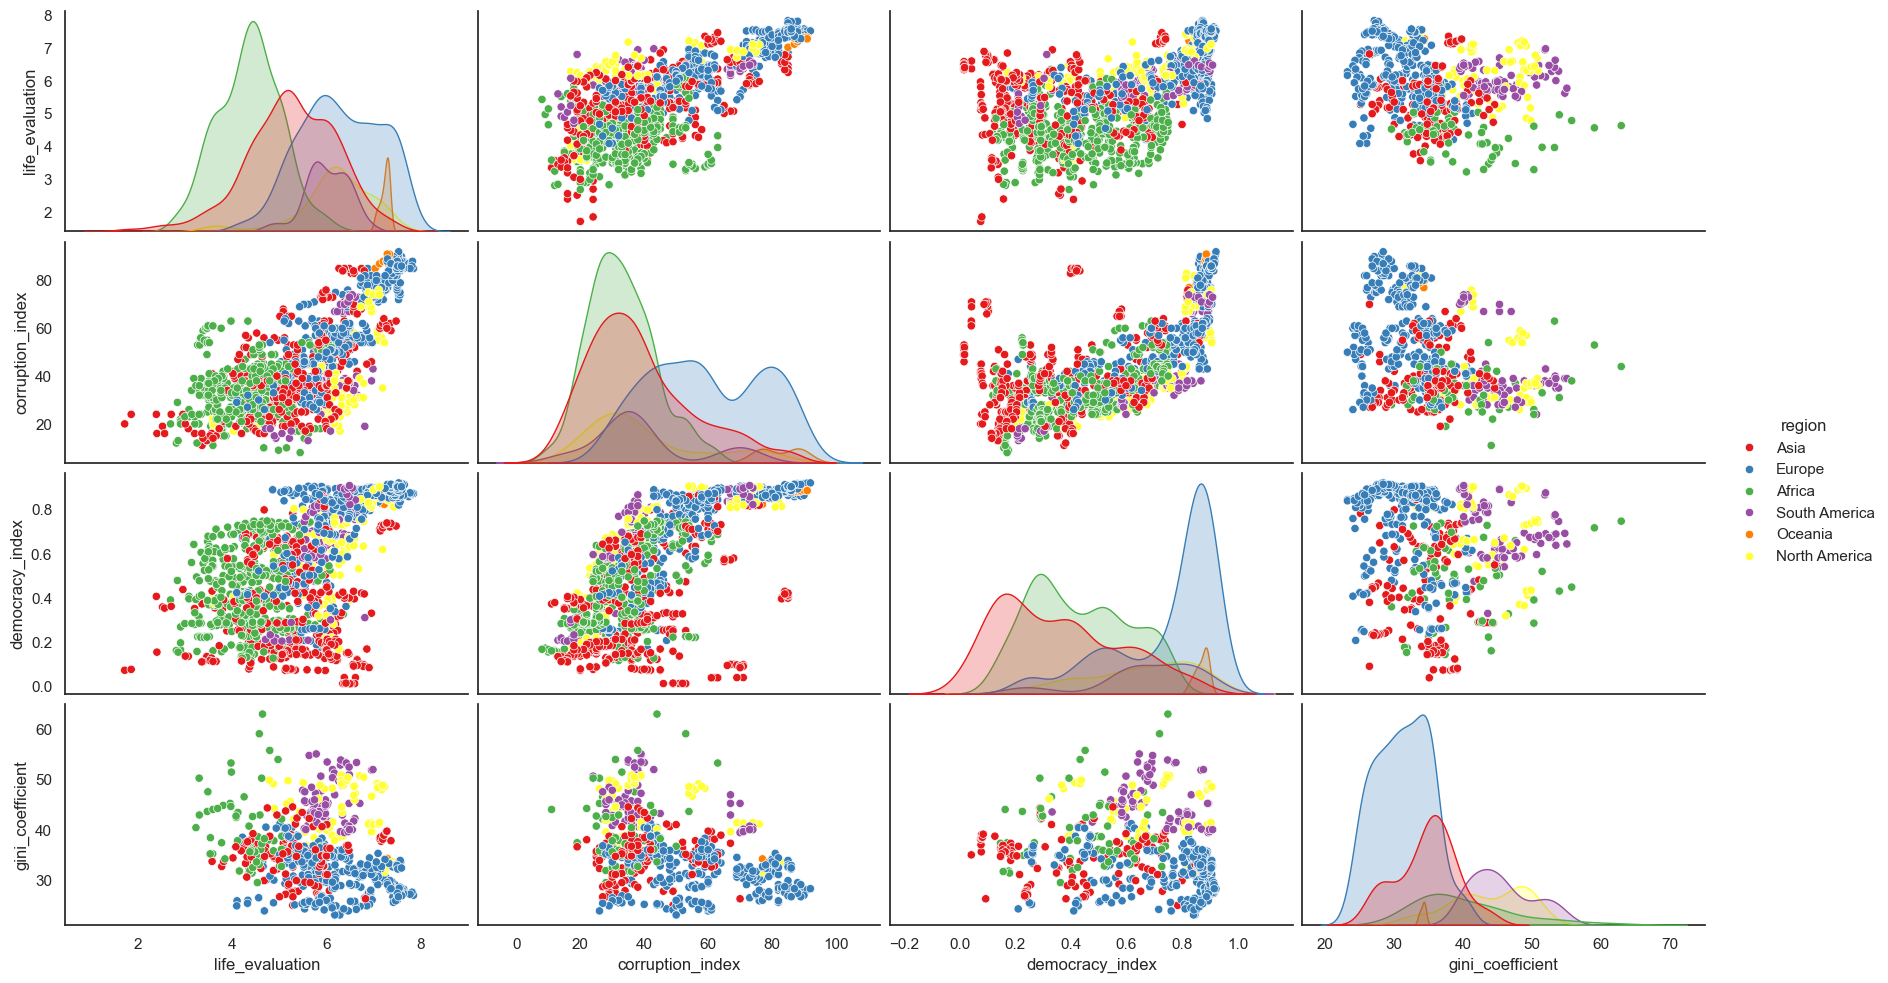

In [5]:
sns.pairplot(data=qogh[['life_evaluation', 'corruption_index', 'democracy_index', 'gini_coefficient', 'region']], hue="region", aspect=1.75);

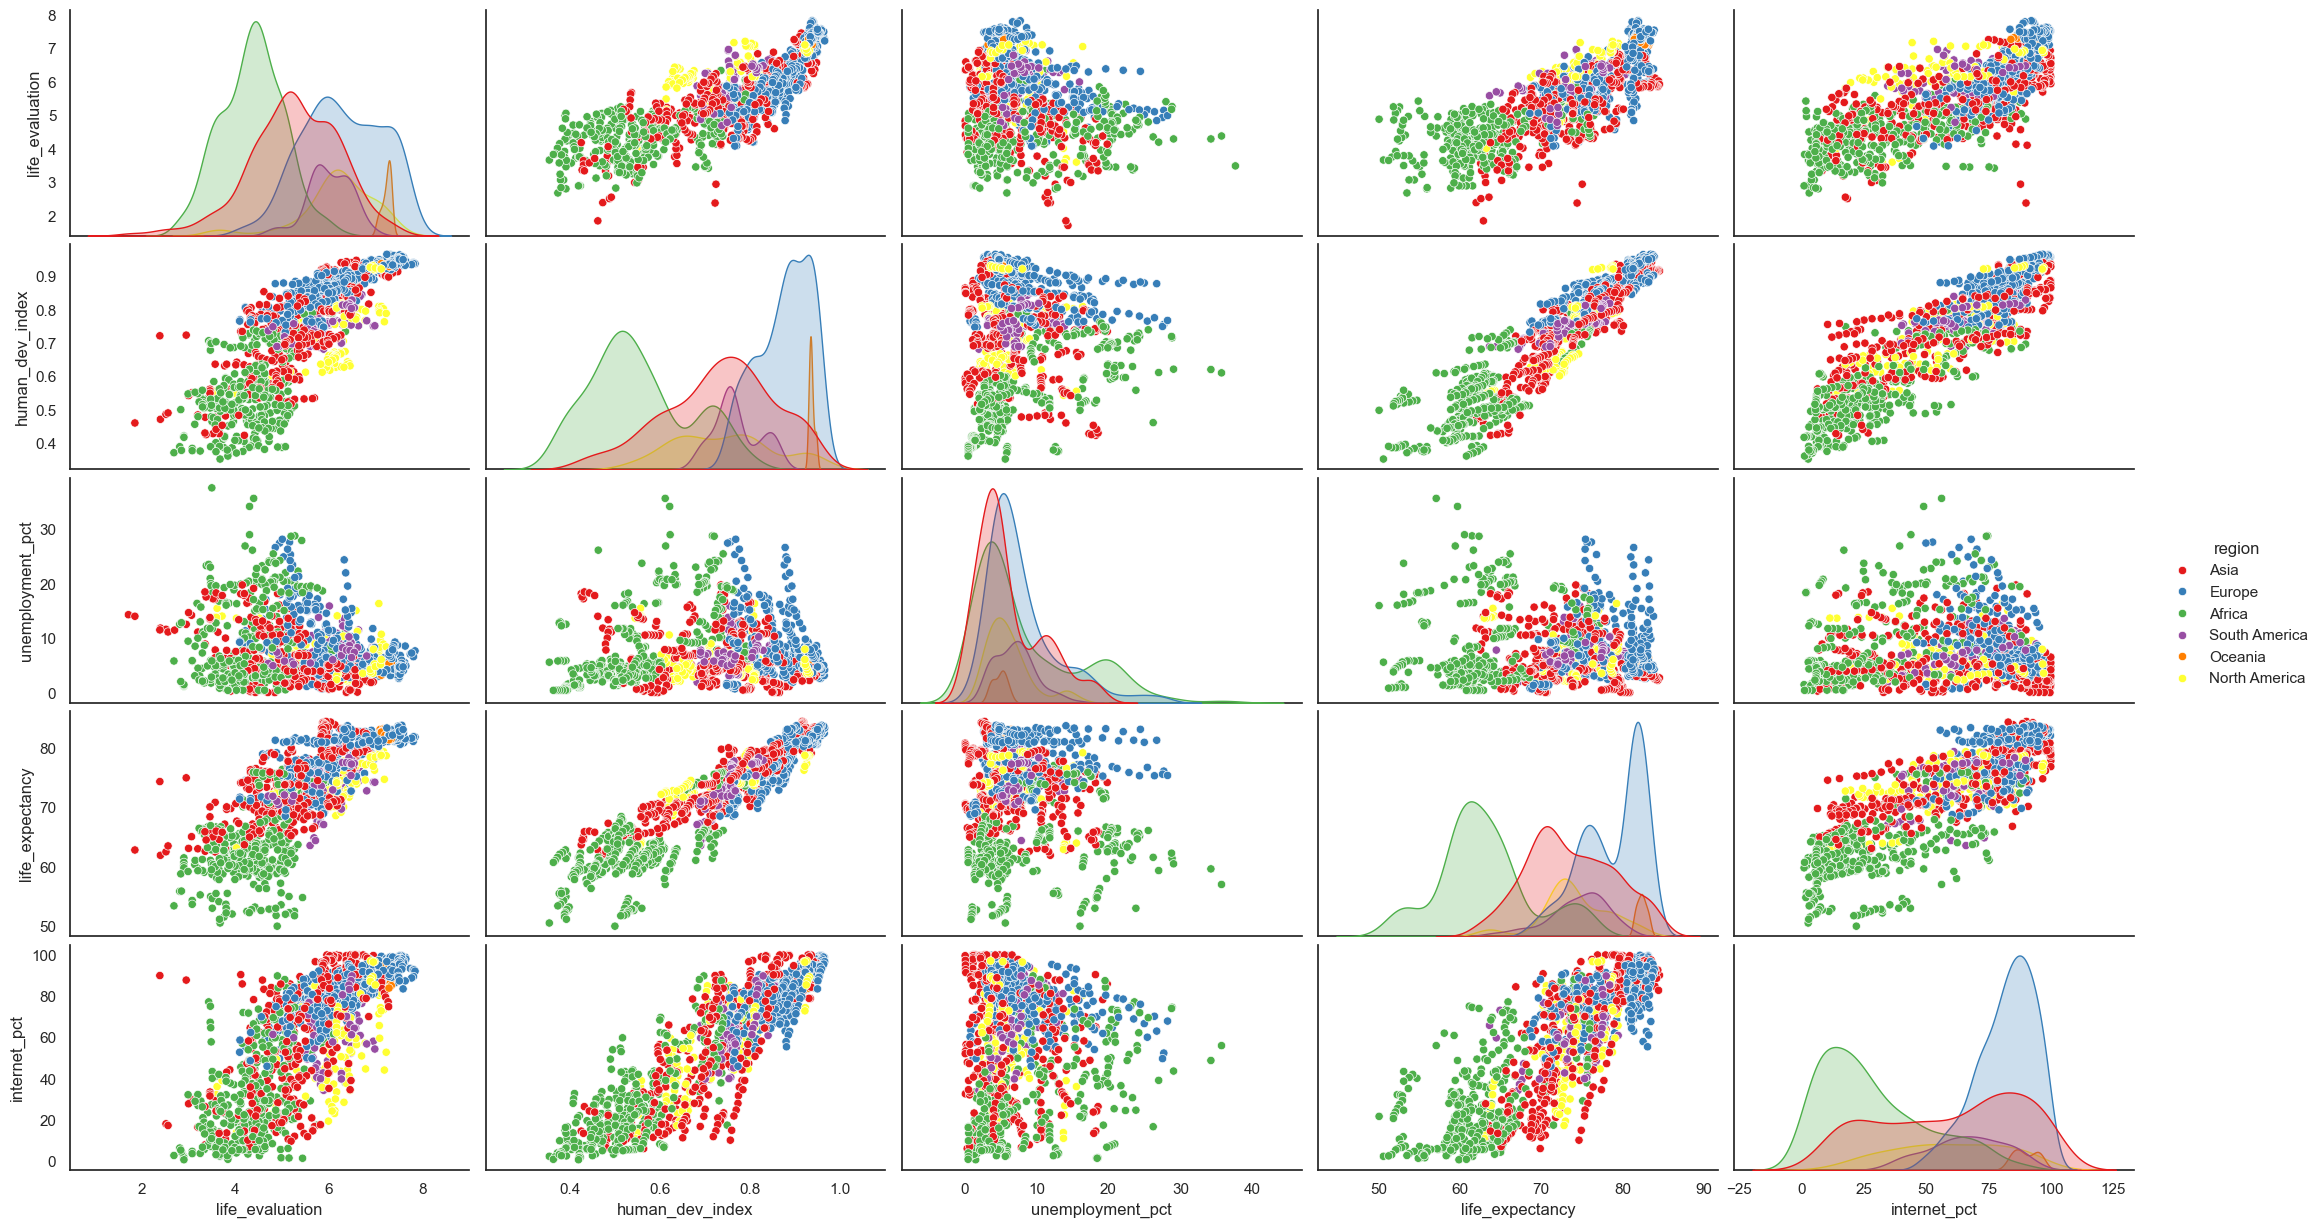

In [6]:
sns.pairplot(
    data=qogh[
        [
            "life_evaluation",
            "human_dev_index",
            "unemployment_pct",
            "life_expectancy",
            "internet_pct",
            "region",
        ]
    ],
    hue="region",
    aspect=1.75
);

`human_dev_index` parece correlacionar bastante bien con `life_expectancy` y `internet_pct`. Vamos a hacer _zoom_ en esto

In [7]:
for var in ["life_expectancy", "internet_pct"]:
    _hdi = "human_dev_index"
    A = df[[_hdi, var]].dropna()
    R = pearsonr(A["human_dev_index"], A[var])
    print(f"`{_hdi}` con `{var}`\ttienen un coeficiente de Pearson-R de {R.statistic:.4f}, con un p-value de {R.pvalue:.4f}")

`human_dev_index` con `life_expectancy`	tienen un coeficiente de Pearson-R de 0.9245, con un p-value de 0.0000
`human_dev_index` con `internet_pct`	tienen un coeficiente de Pearson-R de 0.8994, con un p-value de 0.0000


- `life_expectancy` descartado. Es redundante con `human_dev_index`. Según [Wikipedia](https://es.wikipedia.org/wiki/%C3%8Dndice_de_desarrollo_humano), la esperanza de vida es uno de los tres componentes principales del índice de desarrollo humano.

- `internet_pct` tiene alta correlación con `human_dev_index`, tan fuerte como `life_expectancy`. Podría llegar a introducir información nueva, pero para simplificar el modelo, se va a omitir al menos para GLMs.

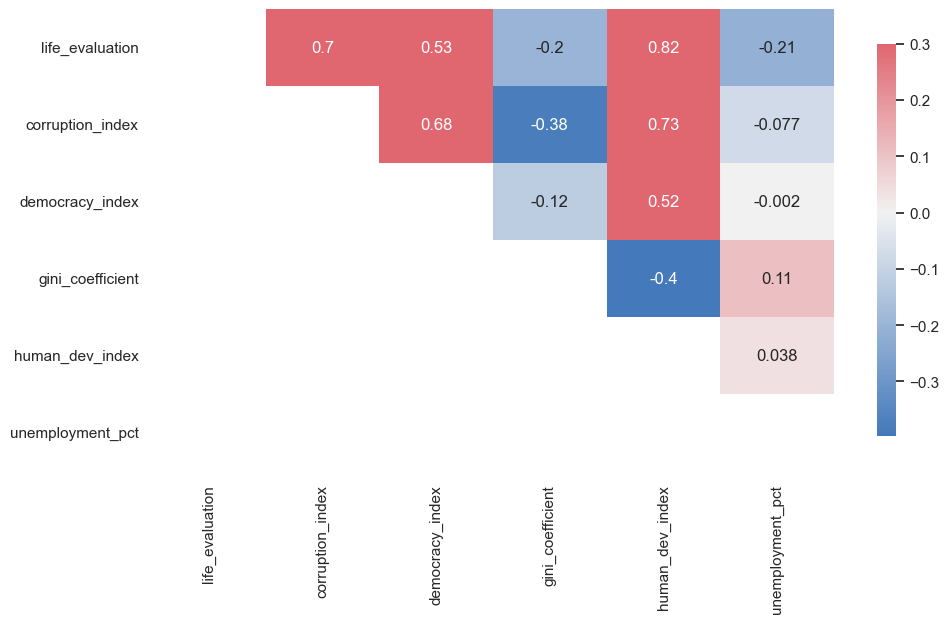

In [8]:
qogh_v2 = qogh[
    [
        "life_evaluation",
        "year",
        "country_name",
        "region",
        "corruption_index",
        "democracy_index",
        "gini_coefficient",
        "human_dev_index",
        "unemployment_pct"
    ]
]

corr = qogh_v2.select_dtypes(include="number").drop(["year"], axis=1).corr()

# Inspirado en https://seaborn.pydata.org/examples/many_pairwise_correlations.html
mask = np.tril(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 6))
cmap = sns.diverging_palette(610, 10, as_cmap=True)
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    center=0,
    annot=True,
    cbar_kws={"shrink": 0.85}
);

---

## Parte **1**: GLMs

El modelo linel lo voy a construir de la siguiente manera:
$$
\text{Índice de Felicidad} \sim \text{Percepción de Corrupción} + \text{Percepción de Democracia} + \text{Índice de Gini} + \text{Índice de Desarollo Humano} + \text{Tasa de Desempleo}
$$

Como hay tanta diferencia entre los rangos de las variables, voy a apoyarme en `StandardScaler` para facilitar el análisis. Voy a construir un modelo lineal jerarquico por paises.

In [9]:
scaler = StandardScaler()
qogh_v2_clean = qogh_v2.dropna().reset_index(drop=True)

glm_Xnums = qogh_v2_clean[
    [
        "corruption_index",
        "democracy_index",
        "gini_coefficient",
        "human_dev_index",
        "unemployment_pct"
    ]
]
glm_X = scaler.fit_transform(glm_Xnums)

glm_y = qogh_v2_clean["life_evaluation"]

cat_encode = pd.Categorical(qogh_v2_clean["country_name"])
idx = cat_encode.codes
coords = {"country_name": cat_encode.categories}

with pm.Model(coords=coords) as hmodel_le:
    # Hiper-priors
    hp_mu = pm.Normal("hp_mu", mu=0, sigma=2)
    hp_sd = pm.HalfNormal("hp_sd", 2)

    # Priors
    alpha = pm.Normal("alpha", mu=hp_mu, sigma=hp_sd, dims="country_name")
    beta = pm.Normal("beta", mu=0, sigma=2, shape=glm_X.shape[1])
    sigma = pm.HalfNormal("sigma", 1)

    # Modelado
    mu = pm.Deterministic("mu", alpha[idx] + pm.math.dot(glm_X, beta))
    y_pred = pm.Normal("y_pred", mu=mu, sigma=sigma, observed=glm_y)

    idata = pm.sample(
        chains=4,
        cores=2,
        target_intercept=0.95,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": {"y_pred": y_pred}},
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [hp_mu, hp_sd, alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


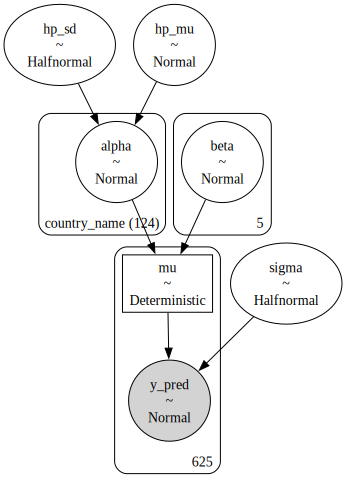

In [10]:
pm.model_to_graphviz(hmodel_le)

In [11]:
az.summary(idata, var_names=["hp_mu", "hp_sd", "beta"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
hp_mu    5.857  0.051   5.759    5.953      0.001    0.001    2659.0   
hp_sd    0.515  0.038   0.447    0.588      0.001    0.001    4550.0   
beta[0]  0.195  0.056   0.086    0.296      0.002    0.001     915.0   
beta[1]  0.054  0.041  -0.022    0.133      0.001    0.001    1458.0   
beta[2] -0.025  0.039  -0.101    0.043      0.001    0.001     825.0   
beta[3]  0.580  0.048   0.482    0.663      0.002    0.001     967.0   
beta[4] -0.258  0.024  -0.307   -0.217      0.001    0.000    1660.0   

         ess_tail  r_hat  
hp_mu      2599.0    1.0  
hp_sd      2869.0    1.0  
beta[0]    1385.0    1.0  
beta[1]    2187.0    1.0  
beta[2]    1499.0    1.0  
beta[3]    1575.0    1.0  
beta[4]    2174.0    1.0

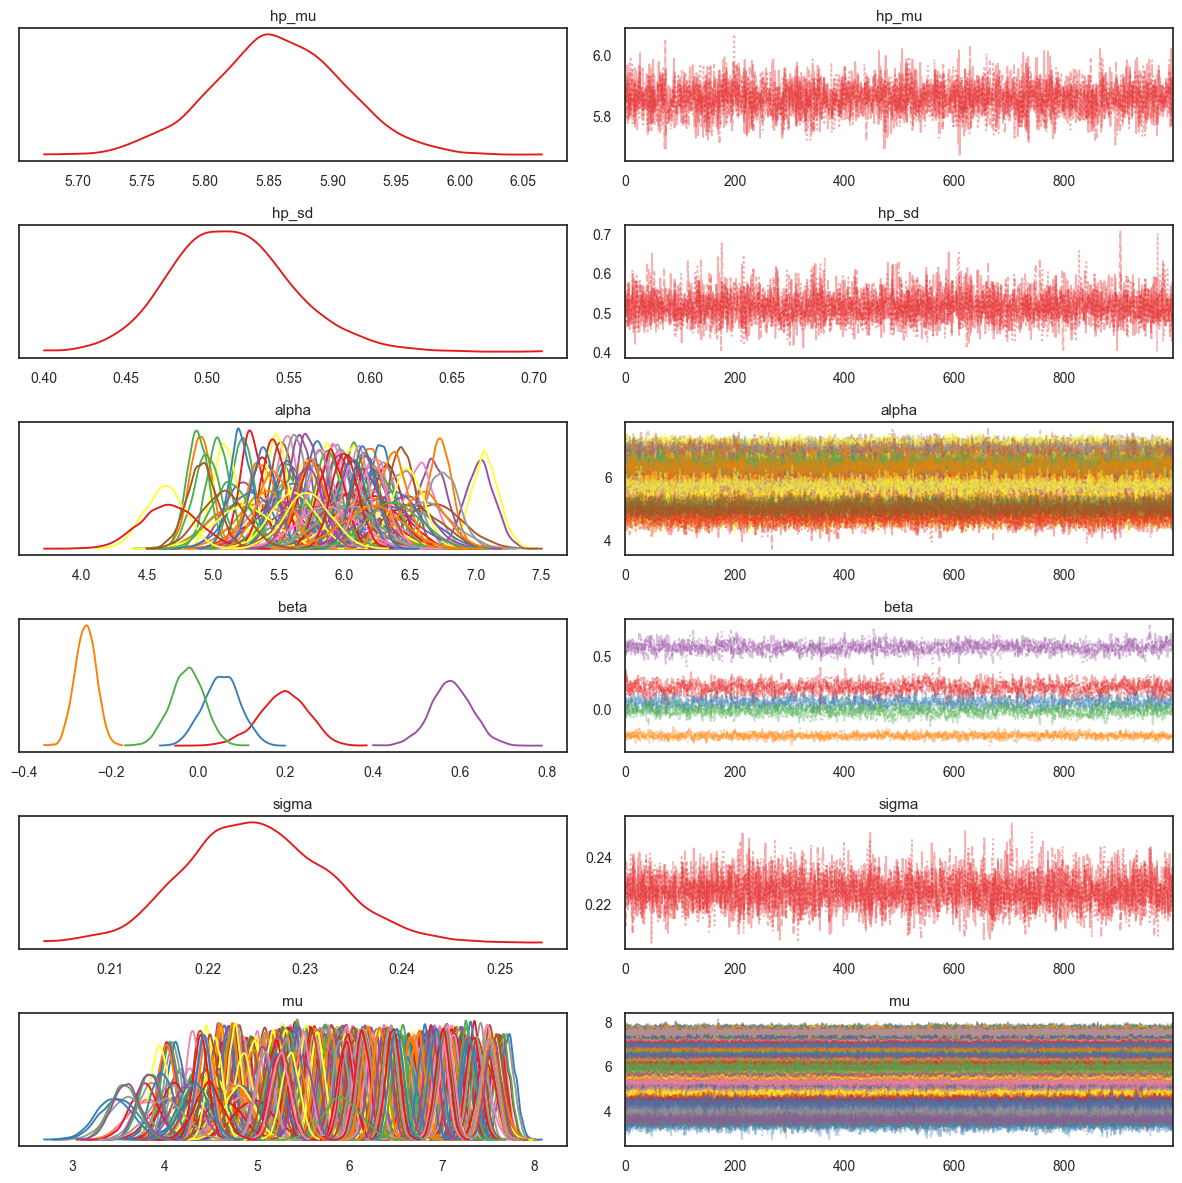

In [12]:
az.plot_trace(idata, var_names=["hp_mu", "hp_sd", "alpha", "beta", "sigma", "mu"], combined=True)
plt.tight_layout()
plt.show()

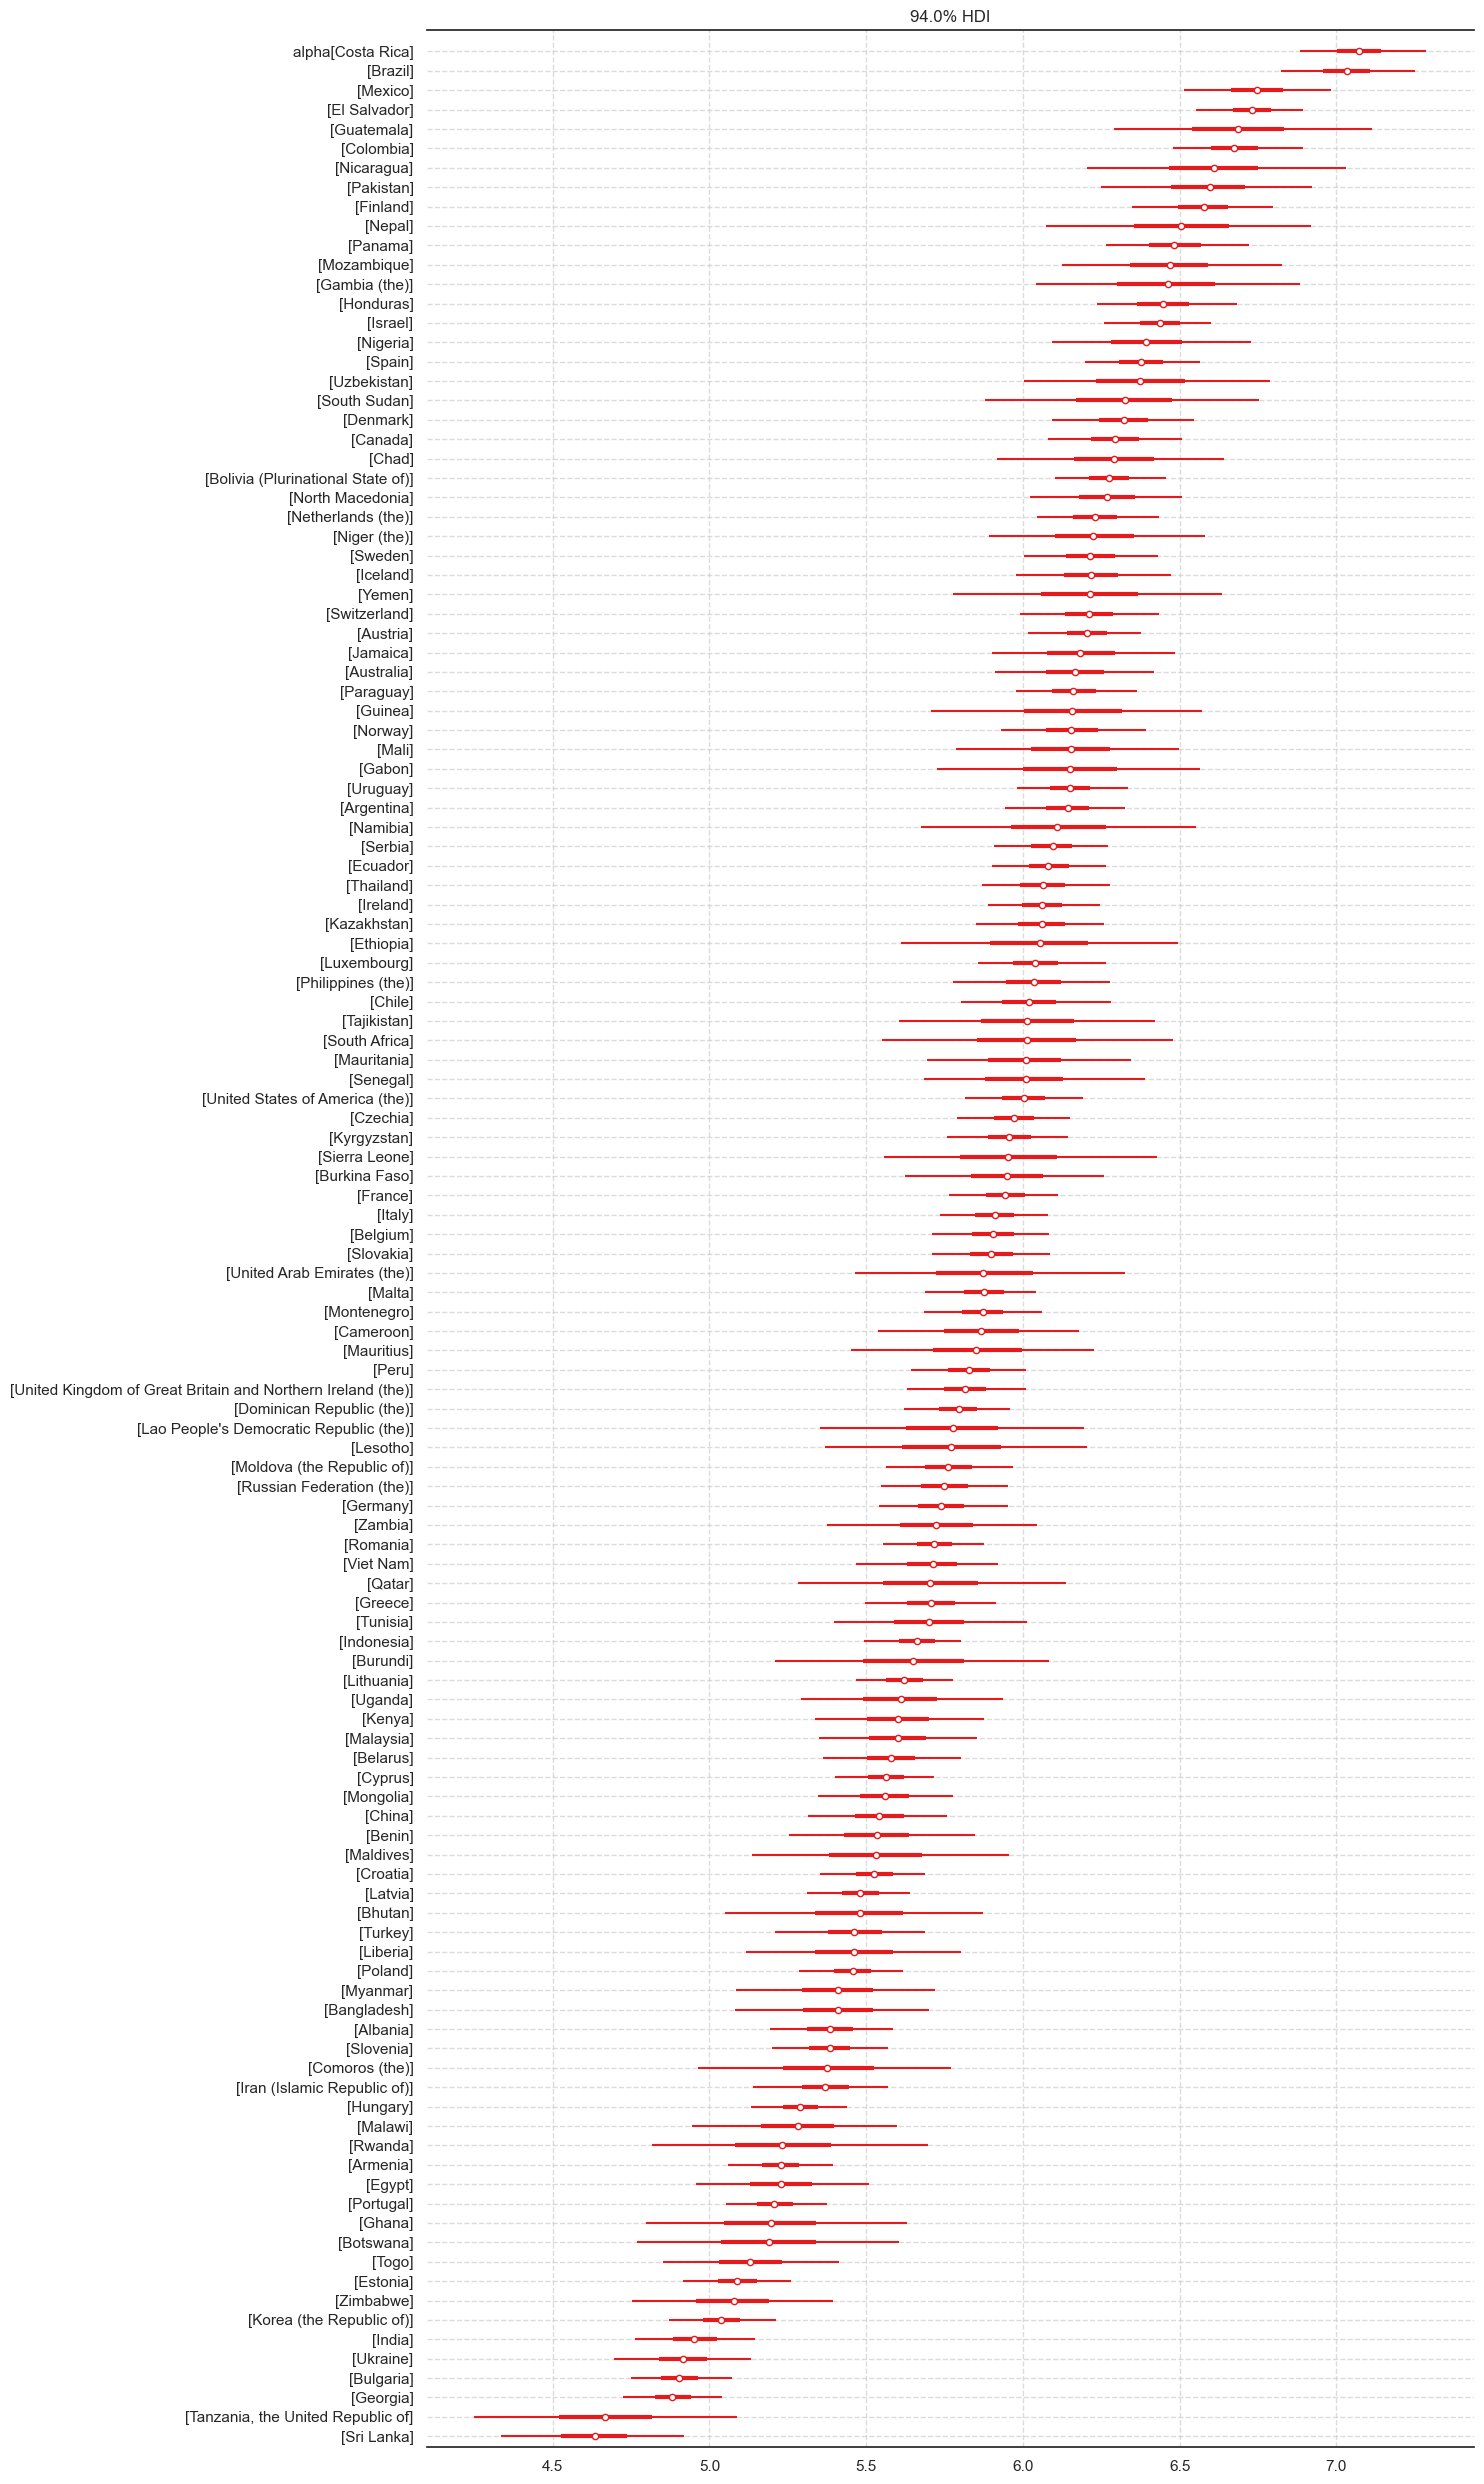

In [13]:
alpha_means = idata.posterior["alpha"].mean(dim=["chain", "draw"])
sorted_countries = (
    alpha_means.sortby(
        alpha_means,
        ascending=False
    )
    .coords["country_name"]
    .values
)

ax = az.plot_forest(
    idata,
    var_names=["alpha"],
    combined=True,
    figsize=(15, 25),
    coords={"country_name": sorted_countries},
)
ax[0].grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Sampling: [y_pred]


Output()

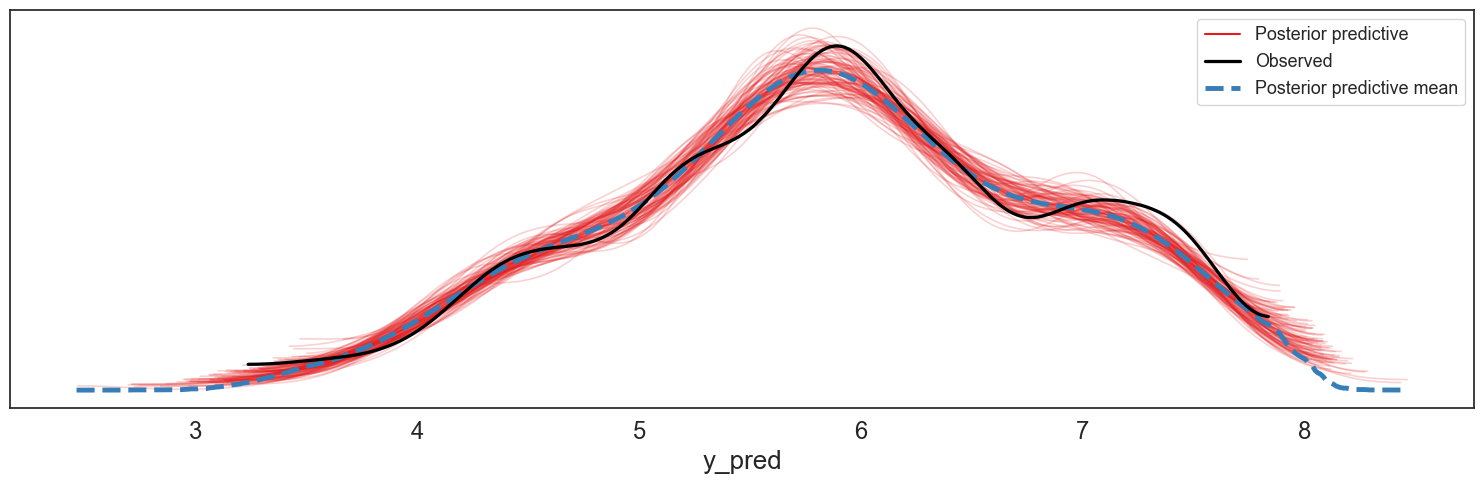

In [14]:
# Primero generá predicciones
with hmodel_le:
    ppc = pm.sample_posterior_predictive(idata)

# Luego visualizá
az.plot_ppc(ppc, num_pp_samples=100, figsize=(15, 5))
plt.tight_layout()
plt.show()

In [15]:
pd.DataFrame(glm_X, columns=glm_Xnums.columns).corr()

corruption_index  democracy_index  gini_coefficient  \
corruption_index          1.000000         0.727217         -0.381384   
democracy_index           0.727217         1.000000         -0.125744   
gini_coefficient         -0.381384        -0.125744          1.000000   
human_dev_index           0.733917         0.580597         -0.397640   
unemployment_pct          0.002605         0.113188          0.113230   

                  human_dev_index  unemployment_pct  
corruption_index         0.733917          0.002605  
democracy_index          0.580597          0.113188  
gini_coefficient        -0.397640          0.113230  
human_dev_index          1.000000          0.146172  
unemployment_pct         0.146172          1.000000

In [16]:
loo_full = az.loo(idata)
print(loo_full)

Computed from 4000 posterior samples and 625 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -41.59    24.33
p_loo      134.31        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      588   94.1%
   (0.70, 1]   (bad)        33    5.3%
   (1, Inf)   (very bad)    4    0.6%



In [17]:
# Variabilidad de Gini dentro vs entre países
gini_within = qogh_v2_clean.groupby('country_name')['gini_coefficient'].std().mean()
gini_between = qogh_v2_clean.groupby('country_name')['gini_coefficient'].mean().std()
print(f"Variabilidad dentro de países: {gini_within:.3f}")
print(f"Variabilidad entre países: {gini_between:.3f}")

Variabilidad dentro de países: 1.357
Variabilidad entre países: 7.457
